In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import scipy as sp
from scipy import optimize

<h><font size="+2"><b> Creación de los datos de juguete para SVM </b></font></b>

<p> Se crearon 3 serts de datos de juguete: </p>

*   El primer set son unos datos concéntricos, los cuales espero separar con un kernel gaussiano
*   El segundo set son uno datos en forma de media luna, los cuales espero separar con kernel polinomial
*   El tercero es un set de datos, aparentemente linealmente separables. A estos no les aplico ningún kernel


In [2]:
N_datos = 500
X_circ, y_circ = datasets.make_circles(n_samples = N_datos, noise = 0.2, factor = 0.7)
X_moon, y_moon = datasets.make_moons(n_samples = N_datos, noise = 0.3)
X_clus, y_clus = datasets.make_blobs(n_samples = N_datos, n_features = 2, centers = ((3,1), (0,5)), cluster_std=1.33)
y_clus = (2*y_clus) - 1
y_moon = (2*y_moon) - 1
y_circ = (2*y_circ) - 1

In [3]:
def normalizar(datos):
    for i in range(len(datos[0,:])):
        datos[:,i] = (1/np.std(datos[:,i]))*(datos[:,i] - np.average(datos[:,i]))
    #fin for 
#fin función
    
#fin función
normalizar(X_circ)
normalizar(X_clus)
normalizar(X_moon)

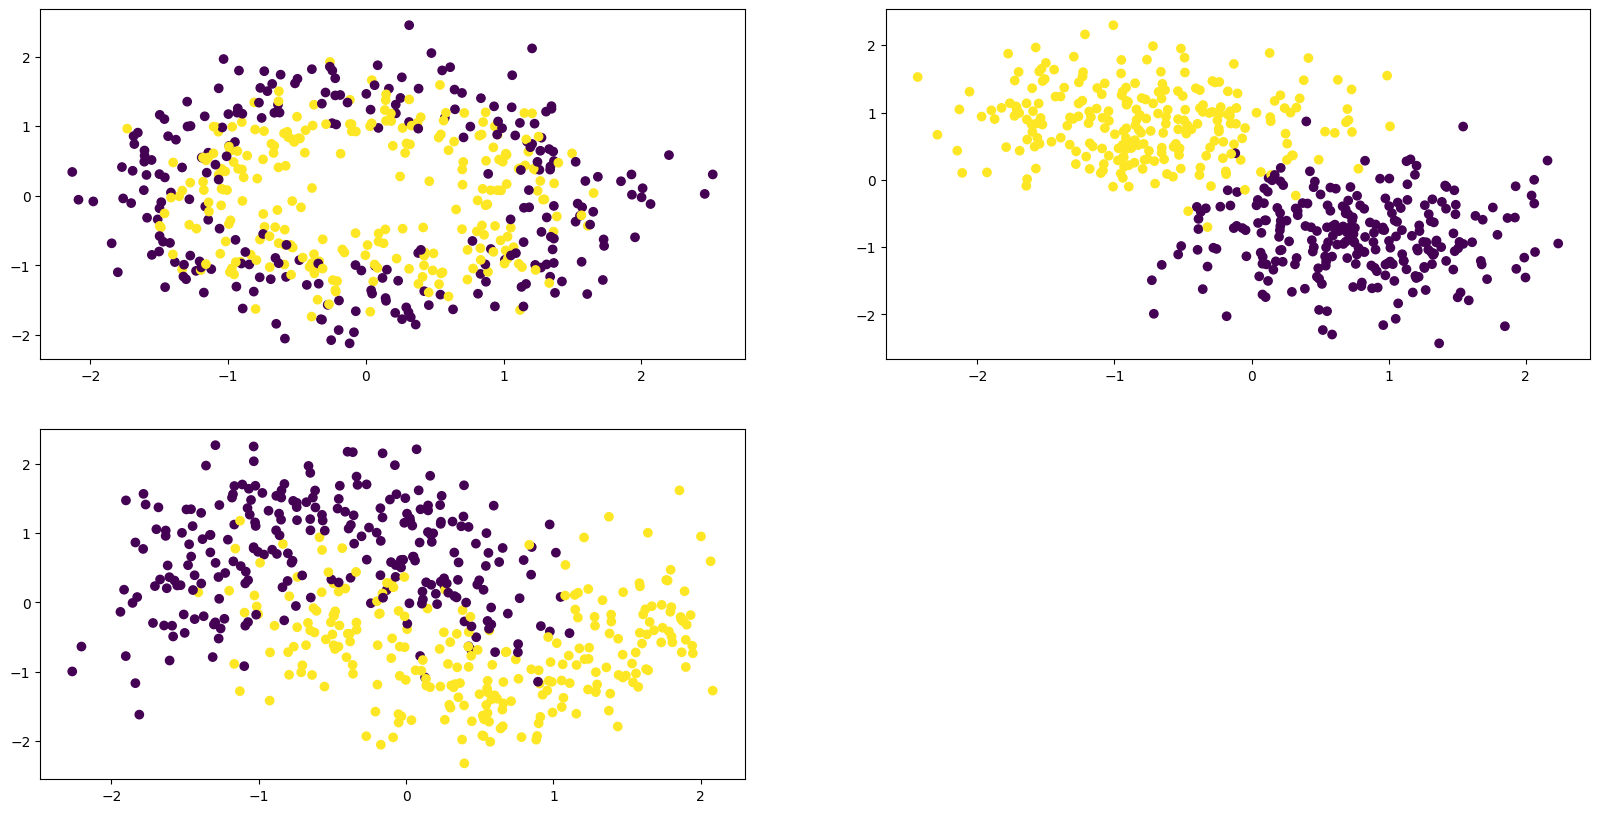

In [4]:
fig1 = plt.figure(figsize = (20, 10))
ax1 = fig1.add_subplot(221)
ax1.scatter(X_circ[:,0], X_circ[:,1], c = y_circ)
ax2 = fig1.add_subplot(222)
ax2.scatter(X_clus[:,0], X_clus[:,1], c = y_clus)
ax3 = fig1.add_subplot(223)
ax3.scatter(X_moon[:,0], X_moon[:,1], c = y_moon)

<h><b> Creación de la función objetivo </b></h>

Aquí podemos ver que esta se creó exitosamente, ya que la función dio lo mismo que evaluandola con la función cutre de ciclos for para aplicar la siguiente fórmula: 

*   $\mathcal{L} = \vec{1^T}\vec{\alpha} - \frac{1}{2}\vec{\alpha^T}\vec{\vec{K}}\vec{\alpha}$

La matriz $\vec{\vec{K}}$ se creó multiplicando cada elemento del vector $\vec{y}$ (vector de las etiquetas) con cada fila (es decir, cada dato) de la matriz de datos $\vec{\vec{X}}$. Es decir, la matriz $\vec{\vec{K}}$ se calculó de la siguiente manera:

*   $\vec{\vec{K}} = (\vec{y}*\vec{\vec{X}})(\vec{y}*\vec{\vec{X}})^T$ 

La matriz de datos $\vec{\vec{X}}$ tiene en cada fila un dato y en cada columna un feature

In [5]:
"""
#Funcion de juguete para probar la funcion del lagrangiano. Ya se probó, ambas funciones retornan lo mismo
def lagrangiano2(alpha, datos, etiquetas):
    suma1 = 0
    suma2 = 0
    N_dat = len(etiquetas)
    for i in range(len(etiquetas)):
        suma1 += alpha[i]
        for j in range(len(etiquetas)):
            suma2 += alpha[i]*alpha[j]*etiquetas[i]*etiquetas[j]*(datos[i,:].dot(datos[j,:]))
        #fin for 
    #fin for 
    lagrangiano = suma1 - 0.5*suma2
    return lagrangiano
#fin funcion          
"""  
def lagrangiano(alpha, datos, etiquetas, kernel = None, parametros_kernel = {}):
    N_datos = len(etiquetas)
    N_features = len(datos[0,:])
    unos = np.ones(N_datos)
    y = np.array([etiquetas]).T
    if kernel == None:
        K = (y*datos).dot((y*datos).T)
    elif kernel == 'polinomial':
        d = parametros_kernel['d']
        mat_kernels = (datos.dot(datos.T))**d
        yT = np.array([y]).T
        K = yT*(y*mat_kernels)
    elif kernel == 'gaussiano':
        sigma = parametros_kernel['sigma']
        X_3D = np.tile(datos.T, (N_datos,1,1))
        Xn = np.array([datos]).reshape(N_datos,N_features,1)
        omega = np.sum((X_3D - Xn)**2, axis=1)
        mat_kernels = np.exp(-omega/(2*sigma**2))
        yT = np.array([y]).T
        K = yT*(y*mat_kernels)
    #fin if 
    lagrangiano = unos.dot(alpha) - 0.5*((alpha.T).dot(K).dot(alpha))
    return -lagrangiano
#fin funcion

In [6]:
alpha_ini = np.random.rand(len(y_clus))
lam_wiki = 1
C = 0.5# 1/(2*lam_wiki*len(y_clus))
restricciones = [{'type': 'ineq', 'fun': lambda x: C-x}, 
                 {'type': 'ineq', 'fun': lambda x: x},
                 {'type': 'eq', 'fun': lambda a,datos,etiquetas: a.dot(etiquetas), 'args': (X_clus,y_clus)}]
resultados_scipy = sp.optimize.minimize(lagrangiano, alpha_ini, args=(X_clus, y_clus), method = 'SLSQP', constraints = restricciones, options = {'disp':True})#, tol = 1e-4, maxiter=50)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -20.789837139870368
            Iterations: 14
            Function evaluations: 7015
            Gradient evaluations: 14


In [7]:
alpha_optimos = np.array(resultados_scipy.x)
print(alpha_optimos)

[-7.41079694e-14  7.68443109e-14  5.31813463e-15 -5.37137570e-14
 -3.30356360e-14 -6.02364425e-14 -3.27310189e-14 -4.91643563e-14
 -5.52341768e-14  7.93234829e-14  5.00000000e-01  6.29005003e-14
  6.44629068e-14 -4.39701624e-15  4.99581613e-13 -5.64302952e-14
 -4.18581855e-14 -5.59434486e-14  3.79709627e-14 -1.97810670e-16
 -9.55703074e-14 -3.31935761e-14  2.57430864e-14  5.00000000e-01
  9.08918101e-13  2.59360937e-14  2.71519714e-15 -1.09146856e-14
  5.00000000e-01  4.96030001e-14 -1.25293662e-13 -2.24515107e-16
  5.00000000e-01 -1.30413700e-14 -6.59860971e-14  5.20807256e-14
 -1.60232866e-14  2.66191765e-13  5.00000000e-01 -1.21606960e-13
 -3.11768498e-14 -2.81840221e-14 -1.06813080e-14  5.00000000e-01
 -2.24010358e-14 -8.37389748e-15 -2.84598530e-14  1.21910216e-14
 -2.33112431e-14 -2.74531181e-14  4.76607678e-14 -3.47487835e-14
  3.19540489e-15  7.08266825e-14  4.51127070e-14  1.08042653e-14
 -8.38081411e-14  1.06053555e-14 -8.41846076e-15 -2.82501355e-14
 -6.98588570e-14  4.45152

In [8]:
np.savetxt('alpha_opt.csv', alpha_optimos, delimiter=',')

In [9]:
w = (alpha_optimos*y_clus).dot(X_clus)
b = np.average(X_clus[alpha_optimos > 1e-6].dot(w) - y_clus[alpha_optimos > 1e-6])

In [10]:
print(w)
print(b)

[-1.46398299  2.48036303]
0.0011555032042695678


Text(0.5, 1.0, 'Ejemplo de clasificación con SVM')

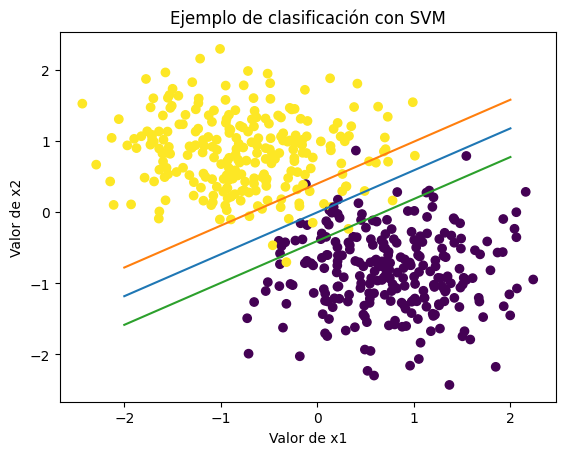

In [12]:
base = np.linspace(-2,2,len(y_clus))
linea = -(b/w[1]) - (w[0]/w[1])*base
linea_plus = (1/w[1]) -(b/w[1]) - (w[0]/w[1])*base
linea_minu = -(1/w[1]) -(b/w[1]) - (w[0]/w[1])*base
fig2 = plt.figure()
ax23 = fig2.add_subplot(111)
ax23.scatter(X_clus[:,0], X_clus[:,1], c = y_clus)
ax23.plot(base, linea, base, linea_plus, base, linea_minu)
ax23.set_xlabel("Valor de x1")
ax23.set_ylabel("Valor de x2")
ax23.set_title("Ejemplo de clasificación con SVM")